In [6]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


In [7]:
from sklearn.model_selection import train_test_split
from opensoundscape import BoxedAnnotations, CNN

In [8]:
metadata = pd.read_csv('./data/metadata.csv')
metadata.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Species,Conf,Call_type,Filename,SiteHab,RecordingSched,RecorderName,DP,SoundFile,SoundFile_path,Split,Raven_path
0,0,0.763354,3.078034,2854.369,5965.410,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
1,1,6.588949,9.475884,2571.297,5451.150,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
2,2,10.434780,12.523959,3085.557,5348.299,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
3,3,14.854197,15.436757,3085.557,5862.558,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
4,4,55.578030,59.479764,2621.359,5475.728,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...


In [9]:
val_metadata=metadata[metadata["Split"]=="validation"]
train_metadata=metadata[metadata["Split"]=="train"]
test_metadata=metadata[metadata["Split"]=="test"]

In [10]:
val_metadata=val_metadata.reset_index()
train_metadata=train_metadata.reset_index()
test_metadata=test_metadata.reset_index()

In [11]:
# assume we have a list of raven annotation files and corresponding audio files
# load the annotations into OpenSoundscape
raven_file_paths = val_metadata['Raven_path']
audio_file_paths = val_metadata['SoundFile_path']
val_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = train_metadata['Raven_path']
audio_file_paths = train_metadata['SoundFile_path']
train_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = test_metadata['Raven_path']
audio_file_paths = test_metadata['SoundFile_path']
test_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

In [12]:
# Create the table with a dataframe
conversion_table = pd.DataFrame(
    {'original':['Eulemur_albifrons', 'Eulemur_fulvus'],
     'new':['Eulemur_sp', 'Eulemur_sp']}
)

# Or create the table in its own spreadsheet
#conversion_table = pd.read_csv('my_conversion_filename_here.csv')

conversion_table

,original,new
0,Eulemur_albifrons,Eulemur_sp
1,Eulemur_fulvus,Eulemur_sp


In [13]:
#correct annotations in each of the splits
val_annotations_corrected = val_annotations.convert_labels(conversion_table)
val_annotations_corrected.audio_files = val_annotations_corrected.df['audio_file'].values #workaround for issue #872
val_annotations_corrected.df.head()

train_annotations_corrected = train_annotations.convert_labels(conversion_table)
train_annotations_corrected.audio_files = train_annotations_corrected.df['audio_file'].values #workaround for issue #872
train_annotations_corrected.df.head()

test_annotations_corrected = test_annotations.convert_labels(conversion_table)
test_annotations_corrected.audio_files = test_annotations_corrected.df['audio_file'].values #workaround for issue #872
test_annotations_corrected.df.head()


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Delta Time (s),Avg Power Density (dB FS/Hz),View,Channel,Conf,Call_type,Delta Freq (Hz),Selection
0,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Hypsipetes_madagascariensis,54.905264,56.190913,1968.454,5223.975,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,1
1,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,4.943181,11.329778,659.794,5690.722,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,1
2,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,13.011363,15.447871,551.700,5773.196,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,2
3,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,17.215908,19.923388,494.845,5773.196,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,3
4,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,24.282540,29.043458,742.268,6103.093,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,4


In [14]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']

In [15]:
# create labels for fixed-duration (5 second) clips
val_labels = val_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

train_labels = train_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

test_labels = test_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

In [18]:
from bioacoustics_model_zoo import Perch

In [19]:
perch_model = Perch()

2025-01-22 16:39:36.088664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 16:39:36.088703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 16:39:36.089638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 16:39:36.094669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 16:39:38.073559: I exter

In [20]:
emb_train = perch_model.embed(train_labels, return_dfs=False, batch_size=128, num_workers=0)
emb_val = perch_model.embed(val_labels, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-01-22 16:39:46.131597: I external/local_xla/xla/service/service.cc:168] XLA service 0x620779060680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 16:39:46.131647: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-01-22 16:39:46.365775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-22 16:39:46.373947: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-01-22 16:39:46.949570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-22 16:39:49.978677: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,160,500,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,160,755

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-22 16:42:23.545479: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In [21]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']



In [22]:
perch_model.change_classes(class_list) # replace fc layer with 1-output layer
quick_fit(perch_model.network, emb_train, train_labels.values, emb_val, val_labels.values,steps=1000)

Epoch 100/1000, Loss: 0.13019047677516937, Val Loss: 0.12718020379543304
val AU ROC: 0.159
val MAP: 0.159


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 200/1000, Loss: 0.07881509512662888, Val Loss: 0.07793813198804855
val AU ROC: 0.253
val MAP: 0.253


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 300/1000, Loss: 0.060844894498586655, Val Loss: 0.06126146391034126
val AU ROC: 0.306
val MAP: 0.306


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 400/1000, Loss: 0.05113308131694794, Val Loss: 0.0527203194797039
val AU ROC: 0.352
val MAP: 0.352


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 500/1000, Loss: 0.04485679790377617, Val Loss: 0.04753447696566582
val AU ROC: 0.406
val MAP: 0.406


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 600/1000, Loss: 0.040397390723228455, Val Loss: 0.04407399892807007
val AU ROC: 0.457
val MAP: 0.457


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 700/1000, Loss: 0.03703058138489723, Val Loss: 0.04161902144551277
val AU ROC: 0.468
val MAP: 0.468


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 800/1000, Loss: 0.0343785434961319, Val Loss: 0.03980417549610138
val AU ROC: 0.482
val MAP: 0.482


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 900/1000, Loss: 0.03222247585654259, Val Loss: 0.038426101207733154
val AU ROC: 0.489
val MAP: 0.489


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 1000/1000, Loss: 0.030425213277339935, Val Loss: 0.037362050265073776
val AU ROC: 0.497
val MAP: 0.497
Training complete


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

In [23]:
val_labels

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                             False   
                                                   5.0        10.0                            False   
                                                   10.0       15.0                            False   
                                                   15.0       20.0                            False   
                                                   20.0       25.0                            False   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                             True   
                                                   40.0       45.0                             True   
                                                   45.0       50.0                             True   
                                                   50.0       55.0                             True   
                                                   55.0       60.0                             True   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                         False   
                                                   40.0       45.0                         False   
                                                   45.0       50.0                         False   
                                                   50.0       55.0                         False   
                                                   55.0       60.0                         False   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                  False   
                                                   5.0        10.0                 False   
                                                   10.0       15.0                 False   
                                                   15.0       20.0                 False   
                                                   20.0       25.0                 False   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                 False   
                                                   40.0       45.0                 False   
                                                   45.0       50.0                 False   
                                                   50.0       55.0                 False   
                                                   55.0       60.0                 False   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

In [24]:
# make predictions by passing the embeddings through the classifier
preds = perch_model.network(torch.tensor(emb_val).float()).detach().numpy()

preds = pd.DataFrame(preds,index=val_labels.index,columns=val_labels.columns)
preds

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          0.003054   
                                                   5.0        10.0                        -2.588068   
                                                   10.0       15.0                        -2.848414   
                                                   15.0       20.0                        -1.996449   
                                                   20.0       25.0                        -2.979095   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                        -1.779525   
                                                   40.0       45.0                        -2.245541   
                                                   45.0       50.0                        -2.192971   
                                                   50.0       55.0                        -2.113440   
                                                   55.0       60.0                        -0.672837   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                      -3.956149   
                                                   5.0        10.0                     -6.025249   
                                                   10.0       15.0                     -6.135106   
                                                   15.0       20.0                     -2.951916   
                                                   20.0       25.0                     -5.055122   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                     -4.269223   
                                                   40.0       45.0                     -4.557839   
                                                   45.0       50.0                     -2.909108   
                                                   50.0       55.0                     -4.163929   
                                                   55.0       60.0                     -3.236210   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0              -4.097684   
                                                   5.0        10.0             -4.200213   
                                                   10.0       15.0             -4.255926   
                                                   15.0       20.0             -4.235997   
                                                   20.0       25.0             -4.055527   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0             -4.766413   
                                                   40.0       45.0             -5.308061   
                                                   45.0       50.0             -4.659304   
                                                   50.0       55.0             -4.824930   
                                                   55.0       60.0             -4.835792   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py

array([0.95397697, 0.9919801 , 0.99303519, 0.99794243, 0.9890857 ,
       0.99169435, 0.99993795, 0.98144611, 0.99922945, 0.96569293,
       0.9797704 ,        nan,        nan, 0.81852103, 0.99683186,
       0.68103331, 0.84133697,        nan, 0.31661017])

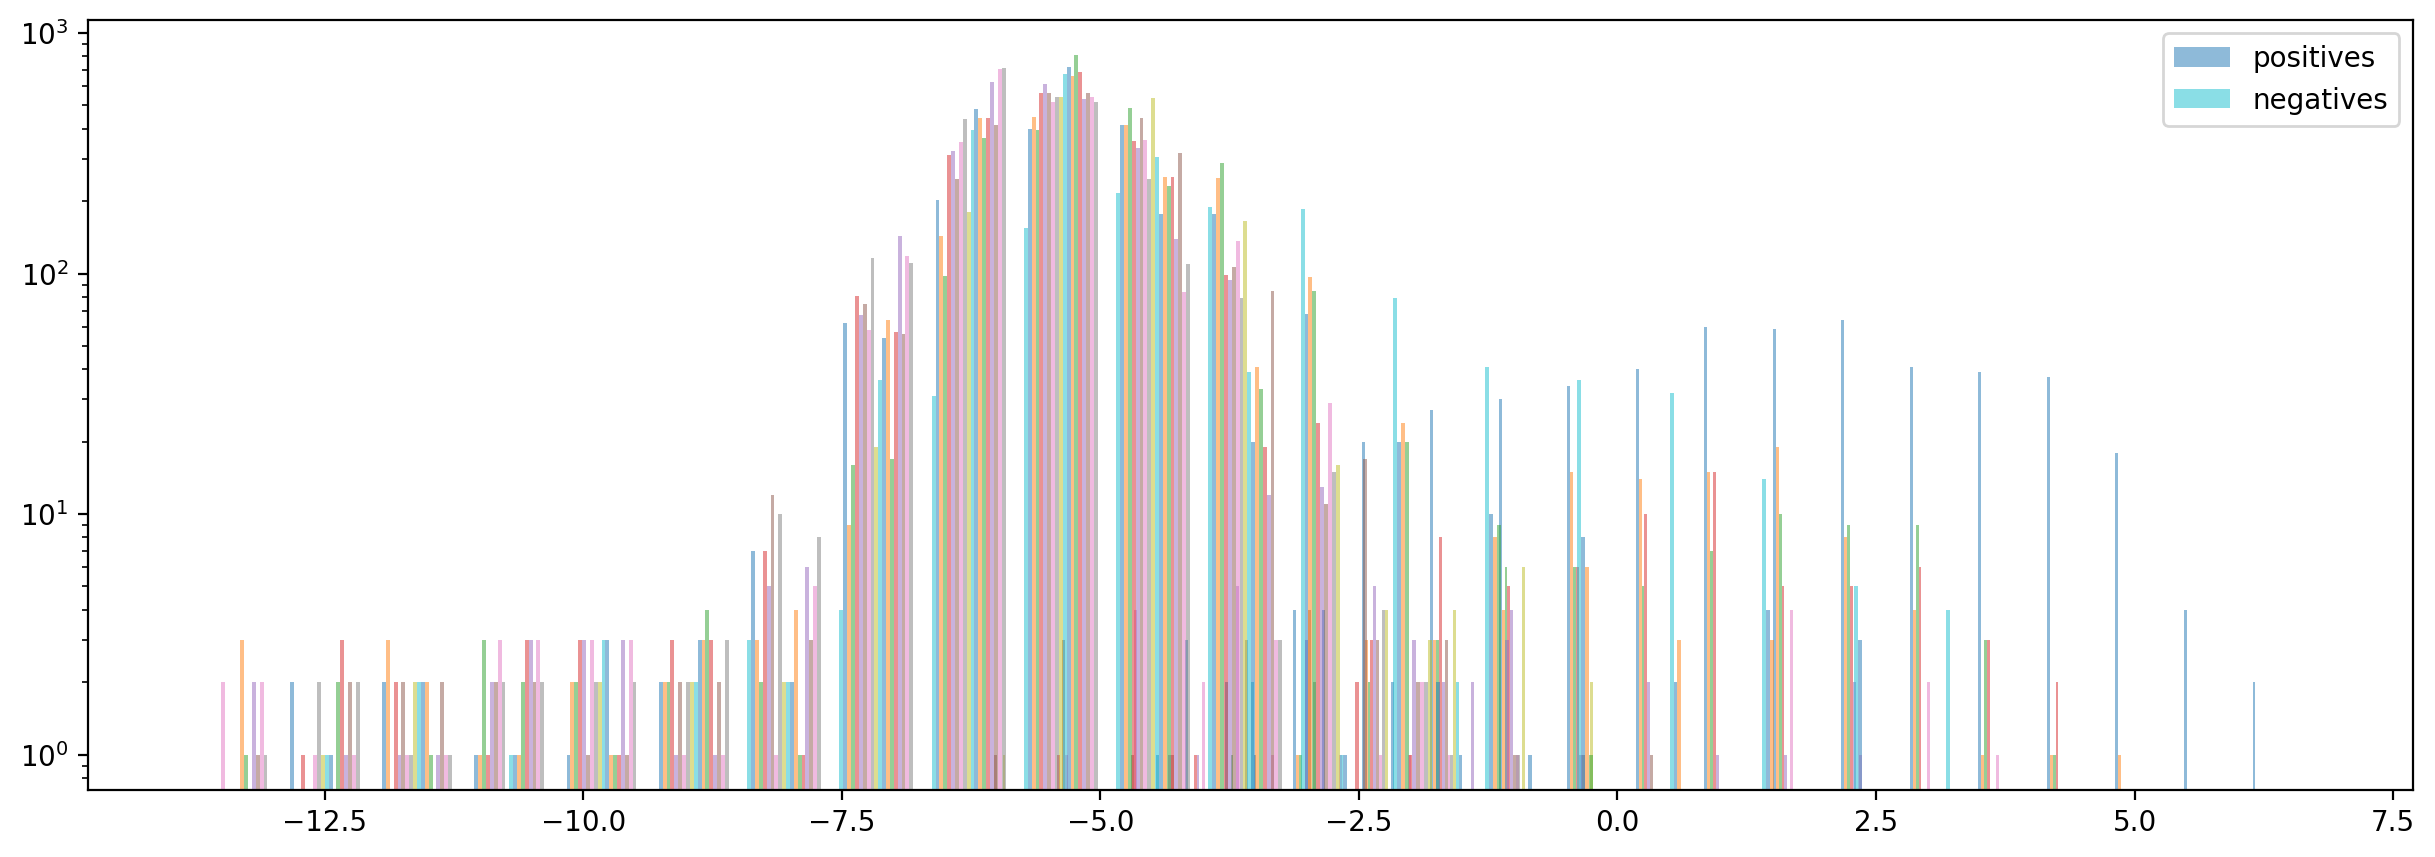

In [25]:

# plot histogram of scores for positive and negative clips
plt.hist(preds[val_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[val_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()
plt.semilogy()

# calculate the area under the ROC score
roc_auc_score(val_labels.values,preds,average=None)

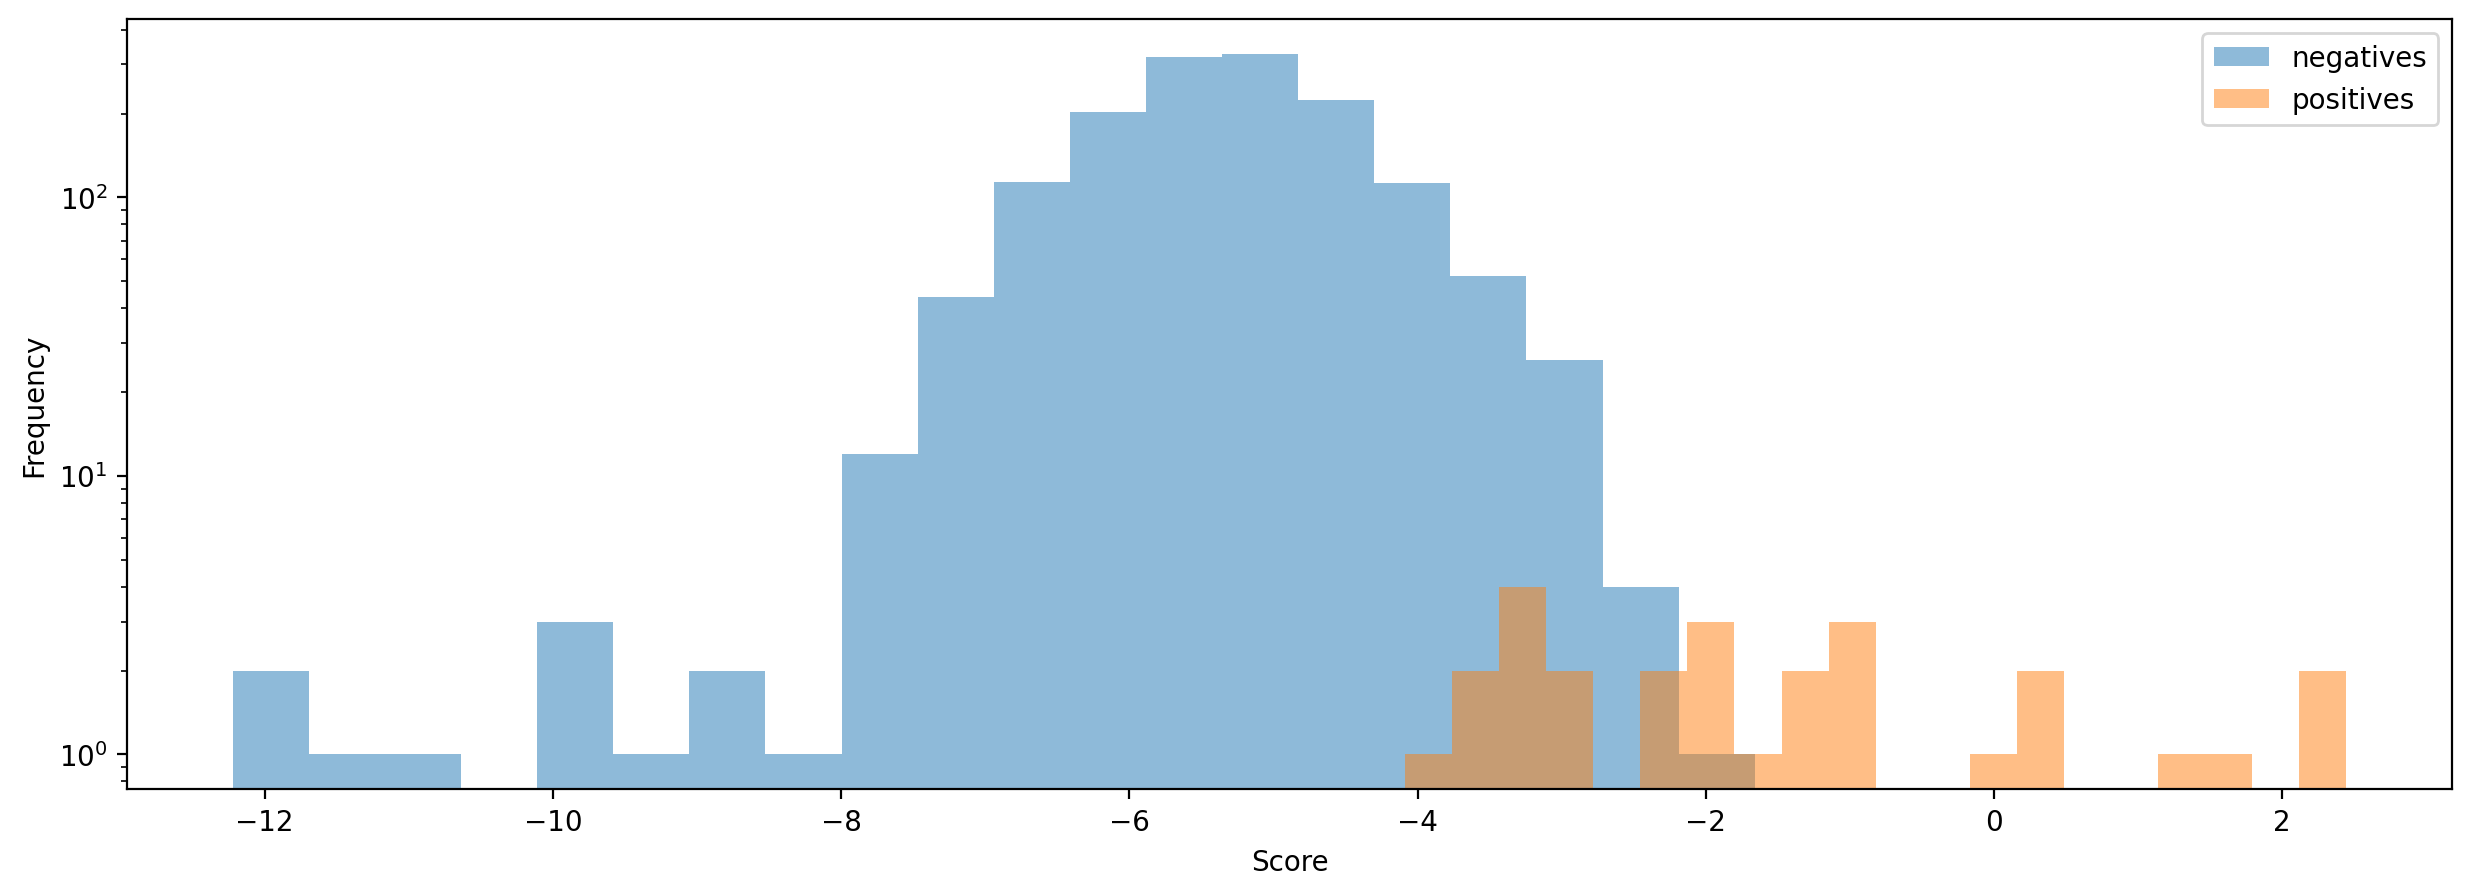

In [26]:
histspecies = 'Coua_caerulea'
# Filter
df_Pos = preds[val_labels==True]
df_NOT = preds[val_labels==False]
# Plot histograms
plt.hist(df_NOT[histspecies],bins=20,alpha=0.5,label='negatives')
plt.hist(df_Pos[histspecies],bins=20,alpha=0.5,label='positives')
# Add a legend and labels
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.semilogy()
# Show the plot
plt.show()

In [27]:
avprecscore_auroc_by_sp = pd.DataFrame(columns=['species', 'avg_precision_score','auroc_score'])
for species in class_list:
    avgscore = sklearn.metrics.average_precision_score(val_labels [species],preds [species])
    auroc = sklearn.metrics.roc_auc_score(val_labels[species],preds [species])
    new_row = pd.DataFrame({'species': [species], 'avg_precision_score': [avgscore], 'auroc_score': [auroc]})
    avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)

avprecscore_auroc_by_sp

/tmp/ipykernel_361597/3174497413.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarni

,species,avg_precision_score,auroc_score
0,Hypsipetes_madagascariensis,0.903167,0.953977
1,Copsychus_albospecularis,0.843859,0.991980
2,Coracopsis_nigra,0.890918,0.993035
3,Dicrurus_forficatus,0.963081,0.997942
4,Coua_caerulea,0.778389,0.989086
5,Zosterops_maderaspatanus,0.584744,0.991694
6,Eurystomus_glaucurus,0.992424,0.999938
7,Agapornis_canus,0.438272,0.981446
8,Saxicola_torquatus,0.926410,0.999229
9,Cyanolanius_madagascarinus,0.517186,0.965693


In [28]:
avprecscore_auroc_by_sp.to_csv(f'/mnt/class_data/group1_bioacoustics/sheila/results/shallow_classifier_perch.csv')